In [24]:
# @title Required installations
# Install necessary libraries
!pip install opencv-python-headless
!pip install torch
!pip install ultralytics
!pip install scikit-image
!pip install scikit-learn
!pip install tqdm
!pip install ColorCorrectionML

In [ ]:
# @title Required libraries
# Import required libraries
import cv2
import torch
import numpy as np
import pandas as pd
import multiprocessing as mp
from ColorCorrectionML import ColorCorrectionML
from ultralytics import YOLO
from tqdm import tqdm
from pathlib import Path
from sklearn.cluster import KMeans
from skimage.morphology import remove_small_holes, remove_small_objects
import matplotlib.pyplot as plt
import contextlib

/usr/local/lib/python3.10/dist-packages/colour/utilities/verbose.py:265: ColourWarning: "vaab/colour" was detected in "sys.path", please define a "COLOUR_SCIENCE__COLOUR__IMPORT_VAAB_COLOUR=True" environment variable to import its objects into "colour" namespace!
  warn(*args, **kwargs)  # noqa: B028


In [ ]:
# @title Required helper functions and classes


def yolo_result_to_sam_input(result, class_name, min_area_px = 10000, min_conf = 0.9):
    # extract info from a YOLOv8 result object and format for use in SAM
    box_confs = result.boxes.conf
    box_classnums = [int(x) for x in result.boxes.cls]
    box_classnames = [result.names[x] for x in box_classnums]
    xy_filt = [x for i,x in enumerate(result.masks.xy) if box_confs[i] > min_conf and box_classnames[i] == class_name]
    classes_filt = [x for i,x in enumerate(box_classnums) if box_confs[i] > min_conf and box_classnames[i] == class_name]
    # convert to a cv2-style contour
    cont_filt = [np.expand_dims(x.astype(np.int32), axis=1) for x in xy_filt]
    cont_filt = [x for x in cont_filt if cv2.contourArea(x) > min_area_px]
    # pull the centroids and convert them into points in SAM format
    moments_filt = [cv2.moments(x) for x in cont_filt]
    fg_points = np.array([(int(M['m10']/M['m00']), int(M['m01']/M['m00'])) for M in moments_filt])
    fg_labels = np.array([1] * fg_points.shape[0])
    return fg_points, fg_labels

def k_means_unknown_k(X, min_k=2, max_k=10):
    # fits kmeans models between min_k and max_k
    # return the one with the highest proportional drop in inertia relative to the model 1 size smaller
    fit_models = [KMeans(init='k-means++', n_clusters=i, n_init=10).fit(X) for i in range(min_k-1, max_k+1)]
    inertias = [x.inertia_ for x in fit_models]
    inertia_ratios = [inertias[(i-1)] / inertias[(i)] for i in range(1, len(inertias))]
    best_model = fit_models[(np.argmax(inertia_ratios)+1)]
    return best_model

def oriented_bounding_box(cnt):
    # from a cv2-generated contour, rotate and create an oriented bounding box in same format as tuple created by cv2.minAreaRect()
    # could expedite by integrating rotate_contour() below, but nice that this is standalone
    (center_x,center_y),(MA,ma),angle = cv2.fitEllipse(cnt)
    xmin = np.min(cnt[:,:,0])
    ymin = np.min(cnt[:,:,1])
    w = np.max(cnt[:,:,0]) - xmin
    h = np.max(cnt[:,:,1]) - ymin
    # make a canvas large enough to fit any arbitrary contour/rotated contour, redraw the contour on it, then rotate
    # draw it such that the center of the ellipse-of-best-fit is exactly at the midpoint
    drawn_cnt = np.zeros((h+w,h+w), dtype = np.uint8)
    cv2.drawContours(drawn_cnt, [cnt - [int(center_x),int(center_y)] + [int((w+h)/2),int((h+w)/2)]], 0, 255, cv2.FILLED)
    rot_matrix = cv2.getRotationMatrix2D(((h+w)/2, (h+w)/2), angle, 1)
    rotated = cv2.warpAffine(drawn_cnt, rot_matrix, (h+w,h+w))
    # redraw contours in order to find oriented bounding box (OBB)
    cnt_rotated, hierarchy = cv2.findContours(rotated, 0, 2)
    obb_x,obb_y,obb_w,obb_h = cv2.boundingRect(cnt_rotated[0])
    # offset vector between oriented rectangle center and ellipse center
    # tends to be small, but makes the annotations cleaner
    center_offset = np.array((obb_x + (obb_w/2) - (w+h)/2, obb_y + (obb_h/2) - (w+h)/2))
    center_offset = np.matmul(center_offset, cv2.getRotationMatrix2D((0,0), angle, 1)[:,0:2])
    rect_center_x = center_x + center_offset[0]
    rect_center_y = center_y + center_offset[1]
    obb = ((rect_center_x, rect_center_y), (obb_w, obb_h), angle)
    return obb

def rotate_contour(cnt):
    # from a cv2-generated contour, rotate it to be oriented vertically (long axis pointed up and down)
    # note: produces a rotated MASK, not a contour
    (center_x,center_y),(MA,ma),angle = cv2.fitEllipse(cnt)
    xmin = np.min(cnt[:,:,0])
    ymin = np.min(cnt[:,:,1])
    w = np.max(cnt[:,:,0]) - xmin
    h = np.max(cnt[:,:,1]) - ymin
    drawn_cnt = np.zeros((h+w,h+w), dtype = np.uint8)
    cv2.drawContours(drawn_cnt, [cnt - [xmin,ymin] + [int(h/2),int(w/2)]], 0, 255, cv2.FILLED)
    rot_matrix = cv2.getRotationMatrix2D((int((w+h)/2), int((w+h)/2)), angle, 1)
    rotated = cv2.warpAffine(drawn_cnt, rot_matrix, (h+w,h+w))
    return rotated

def est_rotated_volume(rotated):
    # from a pre-oriented mask, estimate volume as a series of stacked cylinders 1px high
    # cylinder radius drawn from px width of the rows
    row_sums = np.sum(rotated/255, axis=1)
    radii_px = [x/2 for x in row_sums if x > 0]
    est_vol_px = sum([np.pi * x**2 for x in radii_px])
    return est_vol_px

def est_rotated_surfarea(rotated):
    # from a pre-oriented mask, estimate surface area as a series of stacked frustums, 1px high
    # top and bottom radius of each frustum is taken from the px width of successive pixel rows
    row_sums = np.sum(rotated/255, axis=1)
    radii_px = [x/2 - 1 for x in row_sums if x > 0]
    # lateral SA of frustum is pi(r1 + r2) * sqrt((r1-r2)^2 * h)
    radii_pairs = zip(radii_px[0:(len(radii_px)-1)], radii_px[1:len(radii_px)])
    lateral_sa = [np.pi * (r1 + r2) * ((r1 - r2)**2 + 1)**0.5 for r1, r2 in radii_pairs]
    # add SA of circular "end caps"
    end_cap_sa = np.pi * (radii_px[0]**2 + radii_px[-1]**2)
    est_sa_px = end_cap_sa + np.sum(lateral_sa)
    return est_sa_px

def roundness_mask(mask):
    pts, hierarchy = cv2.findContours(mask, 0, 2)
    _, radius_lrg = cv2.minEnclosingCircle(pts[0])
    dist_map = cv2.distanceTransform(mask, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
    _, radius_sml, _, center = cv2.minMaxLoc(dist_map)
    return (radius_sml-1) / radius_lrg

def roundness_contour(cnt):
    mask = np.zeros((np.max(cnt)*2, np.max(cnt)*2), dtype=np.uint8)
    _, radius_lrg = cv2.minEnclosingCircle(cnt)
    cv2.drawContours(mask, [cnt], 0, 255, cv2.FILLED)
    dist_map = cv2.distanceTransform(mask, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
    _, radius_sml, _, center = cv2.minMaxLoc(dist_map)
    return radius_sml / radius_lrg

def validate_output_df(output_df):
    # can do this at runtime, but doing it last is useful for adjusting which columns are shown
    df = output_df.copy()
    if 'area_cm2' in df.columns:
        size_col = 'area_cm2'
    else:
        size_col = 'area_px2'
    if 'row' in df.columns:
        loc_columns = ['row','column']
    else:
        loc_columns = ['center_px_x', 'center_px_y']
    # flag any low solidity berries, should all be >0.97
    if any(df['solidity'] < 0.95):
        print('Berrie(s) with low solidity found:')
        print(df[df['solidity'] < 0.95][['filename'] + loc_columns + ['solidity']])
    # flag excessive z-scores
    df['mean_size'] = df.groupby('filename')[size_col].transform(lambda x: x.mean())
    df['Z'] = df.groupby('filename')[size_col].transform(lambda x: (x - x.mean()) / x.std())
    if any(abs(df['Z']) > 3):
        print('Berrie(s) >3 standard deviations from mean found:')
        print(df[abs(df['Z']) > 3][['filename'] + loc_columns + [size_col] + ['mean_size','Z']])

class SingleCranImage():
    def __init__(self, Path):
        self.img = cv2.imread(str(Path))
        self.dir = str(Path.parent)
        self.filename = Path.name
        self.gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        self.lab = cv2.cvtColor(self.img, cv2.COLOR_BGR2LAB)
        self.hsv = cv2.cvtColor(self.img, cv2.COLOR_BGR2HSV)
        self.no_berries = False
        self.no_markers = False

    def adjust_color(self, color_method='pls'):
        # first, validate that a color card could be found
        detector = cv2.mcc.CCheckerDetector_create()
        detector.process(self.img, cv2.mcc.MCC24, 1)
        checkers = detector.getListColorChecker()
        if len(checkers) == 0:
            raise Exception('No color card could be found - please check image')
        cc = ColorCorrectionML(self.img)
        kwargs_cc = {
            'method': color_method,
            'interactions_only': False,
            'ncomp': 10, # number of components for PLS only
            'max_iter': 1000, # max iterations for PLS only
            'white_balance_mtd': 0 # 0: no white balance, 1: learningBasedWB, 2: simpleWB, 3: grayWorldWB,
            }
        with contextlib.redirect_stdout(None):
            M, patch_size = cc.compute_correction(
                show=False,
                **kwargs_cc
            )
        self.img = cc.correct_img(self.img)
        self.gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        self.lab = cv2.cvtColor(self.img, cv2.COLOR_BGR2LAB)
        self.hsv = cv2.cvtColor(self.img, cv2.COLOR_BGR2HSV)

    def find_size_markers(self, min_area_px = 10000):
        # size marker detection for non-CNN method, assuming one or more black circles of uniform diameter
        # 10k pixel cutoff size is static - adjust as needed
        _,thr_black = cv2.threshold(self.hsv[:,:,2], 70, 255, cv2.THRESH_BINARY_INV)
        thr_black = remove_small_objects(thr_black.astype(bool), min_area_px).astype(np.uint8) * 255
        marker_contours, hierarchy = cv2.findContours(thr_black, 0, 2)
        marker_contours = [x for x in marker_contours if roundness_contour(x) > 0.95]
        if len(marker_contours == 0):
            self.marker_size_px = np.nan
            self.no_markers = True
        else:
            marker_sizes = [np.mean(cv2.boundingRect(x)[2:4]) for x in marker_contours]
            self.marker_size_px = np.mean(marker_sizes)
        self.marker_contours = marker_contours
        # size markers should be within 1-2% of each other usually, flag if >5%
        if any(abs((marker_sizes - self.marker_size_px)/self.marker_size_px) > 0.05):
            print('Issue in image %s' % self.filename)
            print('Size markers with >5 percent deviation from mean marker size. Check size markers on this image')

    def find_berries(self, whitebg = False):
        if not whitebg:
            # with blue background, easier to read if we select the background, then invert
            # hue should be close to 103 with a blue BG
            nonblue = np.abs(self.hsv[:,:,0].astype(np.int32) - 103)
            nonblue = nonblue.astype(np.uint8)
            _,thr_highblue = cv2.threshold(nonblue, 15, 255, cv2.THRESH_BINARY_INV)
            # white objects can take on blueish tint, so select on moderately high saturation (paper ~ 40, background ~200)
            _,thr_sat = cv2.threshold(self.hsv[:,:,1], 100, 255, cv2.THRESH_BINARY)
            # black berries reflect blueish bg on edges, so select moderately bright objects
            _,thr_val = cv2.threshold(self.hsv[:,:,2], 100, 255, cv2.THRESH_BINARY)
            thr_bg = cv2.bitwise_and(thr_highblue, cv2.bitwise_and(thr_sat, thr_val))
            thr_fg = 255 - thr_bg
        else:
            # high saturation grabs unripe/ripe berries
            _,thr_sat = cv2.threshold(self.hsv[:,:,1], 40, 255, cv2.THRESH_BINARY)
            # low value grabs dark berries and size markers
            _,thr_val = cv2.threshold(self.hsv[:,:,2], 120, 255, cv2.THRESH_BINARY_INV)
            thr_fg = cv2.bitwise_or(thr_sat, thr_val)
        # fill holes, smooth to remove hairs, remove small objects, then remove very large objects (color card, label, etc)
        thr_fg = remove_small_holes(thr_fg.astype(bool), 50000).astype(np.uint8) * 255
        thr_fg = cv2.morphologyEx(thr_fg, cv2.MORPH_OPEN, kernel=np.ones((7,7)))
        thr_fg = remove_small_objects(thr_fg.astype(bool), 2000).astype(np.uint8) * 255
        berries_removed = remove_small_objects(thr_fg.astype(bool), 200000).astype(np.uint8) * 255
        thresh_for_berries = thr_fg - berries_removed
        berry_contours, hierarchy = cv2.findContours(thresh_for_berries, 0, 2)
        # with white BG, the markers are hard to separate out from berries
        # keep them if they are smaller (markers about 70k px in pics so far) or sufficiently non-round
        if whitebg:
            berry_contours = [x for x in berry_contours if cv2.contourArea(x) < 50000 or roundness_contour(x) < 0.93]
        # downstream metrics and useful objects
        self.berry_contours = berry_contours
        if len(berry_contours == 0):
            # TODO - possible - throw warning if no berries found
            self.no_berries = True
        self.berry_moments = [cv2.moments(x) for x in berry_contours]
        self.obb_list = [oriented_bounding_box(x) for x in berry_contours]
        self.rotated_masks = [rotate_contour(x) for x in berry_contours]

    def find_objects_yolo(self, model, yolo_imgsz = 3200, min_conf = 0.7, min_area_px = 10000):
        # read in model and validate imgsz
        if yolo_imgsz % 32 != 0:
            raise Exception('yolo_imgsz is %s, must be multiple of 32' % yolo_imgsz)
        # predict and extract info
        result = model.predict(self.img, imgsz=self.img.shape[0:2], verbose=False)[0]
        box_confs = result.boxes.conf
        box_classnums = [int(x) for x in result.boxes.cls]
        box_classnames = [result.names[x] for x in box_classnums]
        cran_xy = [x for i,x in enumerate(result.masks.xy) if box_confs[i] > min_conf and box_classnames[i] == 'cranberry']
        berry_contours = [np.expand_dims(x.astype(np.int32), axis=1) for x in cran_xy]
        # useful to have in a generous px area filter
        # shouldn't have any tiny false positives, but it's hard to anticipate the range of debris etc
        self.berry_contours = [x for x in berry_contours if cv2.contourArea(x) > min_area_px]
        # save objects for later
        self.berry_moments = [cv2.moments(x) for x in self.berry_contours]
        self.obb_list = [oriented_bounding_box(x) for x in self.berry_contours]
        self.rotated_masks = [rotate_contour(x) for x in self.berry_contours]
        # may be no markers found, not all images have black size markers
        marker_xy = [x for i,x in enumerate(result.masks.xy) if box_confs[i] > min_conf and box_classnames[i] == 'sizemarker_black']
        if len(marker_xy) == 0:
            self.no_markers = True
            self.marker_contours = []
            self.marker_size_px = np.nan
        else:
            marker_contours = [np.expand_dims(x.astype(np.int32), axis=1) for x in marker_xy]
            marker_sizes = [np.mean(cv2.boundingRect(x)[2:4]) for x in marker_contours]
            self.marker_size_px = np.mean(marker_sizes)
            self.marker_contours = marker_contours
            # size markers should be within 1-2% of each other usually, flag if >5%
            if any(abs((marker_sizes - self.marker_size_px)/self.marker_size_px) > 0.05):
                print('Issue in image %s' % self.filename)
                print('Size markers with >5 percent deviation from mean marker size. Check size markers on this image')

    def measure_berries(self):
        # defining columns one at a time like this is a bit clunky
        # but it's legible and explicit, which is useful
        berry_df = pd.DataFrame()
        berry_df['berry'] = [x+1 for x in list(range(len(self.berry_contours)))]
        berry_df['length_px'] = [obb[1][1] for obb in self.obb_list]
        berry_df['width_px'] = [obb[1][0] for obb in self.obb_list]
        berry_df['length_vs_width'] = berry_df['length_px']/berry_df['width_px']
        berry_df['area_px2'] = [int(cv2.contourArea(cnt)) for cnt in self.berry_contours]
        berry_df['perimeter_px'] = [int(cv2.arcLength(cnt, True)) for cnt in self.berry_contours]
        berry_df['solidity'] = [cv2.contourArea(cnt)/cv2.contourArea(cv2.convexHull(cnt)) for cnt in self.berry_contours]
        berry_df['roundness'] = [roundness_contour(cnt) for cnt in self.berry_contours]
        berry_df['est_volume_px3'] = [int(est_rotated_volume(rot)) for rot in self.rotated_masks]
        berry_df['est_surfarea_px2'] = [int(est_rotated_surfarea(rot)) for rot in self.rotated_masks]
        berry_df['center_px_x'] = [int(obb[0][0]) for obb in self.obb_list]
        berry_df['center_px_y'] = [int(obb[0][1]) for obb in self.obb_list]
        # insert file/path last so single value nicely scales up to n rows
        berry_df.insert(0, 'filename', self.filename)
        berry_df.insert(0, 'dir', self.dir)
        self.berry_df = berry_df

    def sort_berries(self):
        # sort berries (and output df) into rows and columns via k means clustering
        best_clust = k_means_unknown_k(self.berry_df[['center_px_y']])
        # kmeans labels are in random order, need to order and shift from 0-index to 1-index
        row_positions = list(best_clust.cluster_centers_[:,0])
        row_indices = [sorted(row_positions).index(i)+1 for i in row_positions]
        self.berry_df.insert(3, "row", [row_indices[x] for x in best_clust.labels_])
        # sort via row/x pos, get columns as list of lists
        self.berry_df = self.berry_df.sort_values(by=['row','center_px_x'])
        rows = list(self.berry_df['row'])
        columns = [list(range(rows.count(x))) for x in set(rows)]
        # flatten the list of lists, make 1-indexed instead of 0-indexed, renumber berries
        columns = [pos+1 for sublist in columns for pos in sublist]
        self.berry_df.insert(4, 'column', columns)
        self.berry_df['berry'] = list(range(1, self.berry_df.shape[0]+1))

    def measure_color(self):
        # separate/calculate color channels
        black = np.zeros_like(self.gray)
        lab = self.lab.astype(np.int32)
        L,a,b = np.split(lab, 3, axis=2)
        a -= 128
        b -= 128
        B,G,R = np.split(self.img, 3, axis=2)
        # from contours, create a list of indices of pixels within the contour bounds (after eroding 10px)
        # eroding 10-px border of each berry mask reduces noise from slivers of background, reflection, etc
        kernel = np.ones((10,10), np.uint8)
        contour_idxs = []
        for i in range(len(self.berry_contours)):
            mask = black.copy()
            mask = cv2.drawContours(mask, self.berry_contours, i, 255, cv2.FILLED)
            mask = cv2.erode(mask, kernel)
            contour_idxs.append(np.where(mask))
        def append_color_metrics(layer, idx_list, name):
            val_list = [layer[idx] for idx in idx_list]
            self.berry_df['color_%s_median' % name] = [np.median(x) for x in val_list]
            self.berry_df['color_%s_sd' % name] = [np.std(x) for x in val_list]
        # discussed HSV but decided it doesn't add a ton
        # L*a*b* generally most informative
        append_color_metrics(L, contour_idxs, 'L')
        append_color_metrics(a, contour_idxs, 'a')
        append_color_metrics(b, contour_idxs, 'b')
        append_color_metrics(R, contour_idxs, 'R')
        append_color_metrics(G, contour_idxs, 'G')
        append_color_metrics(B, contour_idxs, 'B')

    def convert_to_cm(self, size_in_cm):
        # could make more elegant than writing out every conversion, but this is legible + explicit
        cm_per_px = size_in_cm / self.marker_size_px
        berry_df = self.berry_df
        berry_df['length_px'] = berry_df['length_px'] * cm_per_px
        berry_df['width_px'] = berry_df['width_px'] * cm_per_px
        berry_df['perimeter_px'] = berry_df['perimeter_px'] * cm_per_px
        berry_df['area_px2'] = berry_df['area_px2'] * (cm_per_px ** 2)
        berry_df['est_surfarea_px2'] = berry_df['est_surfarea_px2'] * (cm_per_px ** 2)
        berry_df['est_volume_px3'] = berry_df['est_volume_px3'] * (cm_per_px ** 3)
        berry_df = berry_df.rename(columns = {
            'length_px':'length_cm',
            'width_px':'width_cm',
            'perimeter_px':'perimeter_cm',
            'area_px2':'area_cm2',
            'est_surfarea_px2':'est_surfarea_cm2',
            'est_volume_px3':'est_volume_cm3'})
        self.berry_df = berry_df

    def save_annotations(self, annot_dir):
        tmp = self.img.copy()
        cv2.drawContours(tmp, self.berry_contours, -1, (0,255,0), 5)
        cv2.drawContours(tmp, self.marker_contours, -1, (0,0,255), 5)
        for obb in self.obb_list:
            obb_coords = cv2.boxPoints(obb)
            obb_coords = np.intp(obb_coords)
            cv2.drawContours(tmp, [obb_coords], 0, (255,0,255), 5)
        outpath = '%s/%s_annotated%s' % (str(annot_dir), Path(self.filename).stem, Path(self.filename).suffix)
        cv2.imwrite(outpath, tmp)



def show_image(image, title='Image'):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [25]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load and process a single image for demo purposes
single_image_path = Path('/content/drive/MyDrive/Cranberry/BerryPortraits/images/1-5_rep1_h1.jpg')
yolo_model_path = Path('/content/drive/MyDrive/Cranberry/BerryPortraits/model_weights/yolov8s_weights.pt')

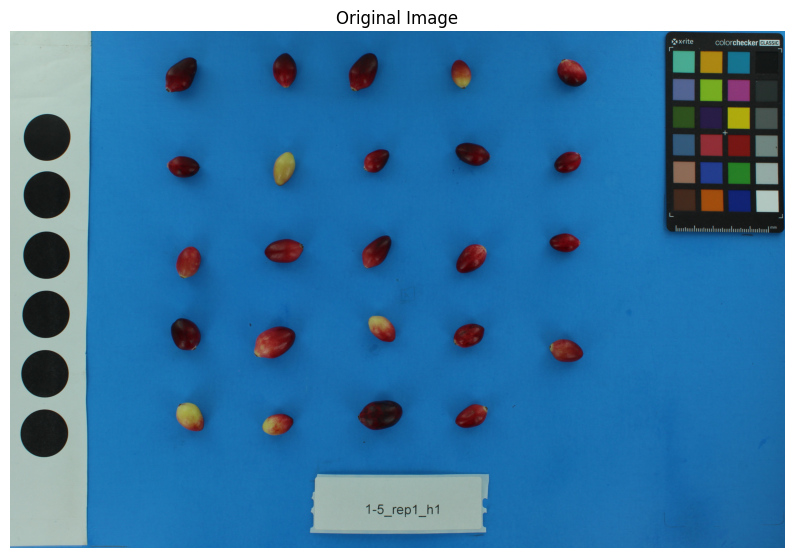

In [ ]:
# Step 1: Load the image
cran = SingleCranImage(single_image_path)
show_image(cran.img, title='Original Image')

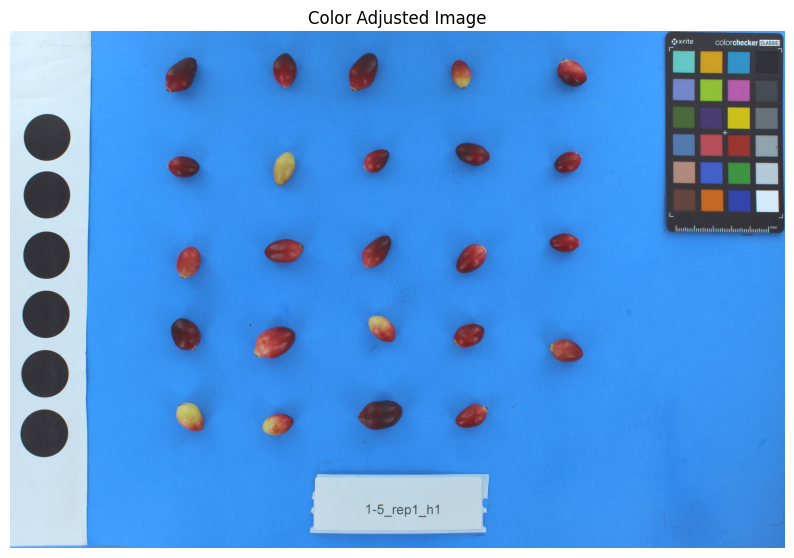

In [ ]:
# Step 2: (Optional) Adjust color
cran.adjust_color(color_method='linear')
show_image(cran.img, title='Color Adjusted Image')

Loading models...


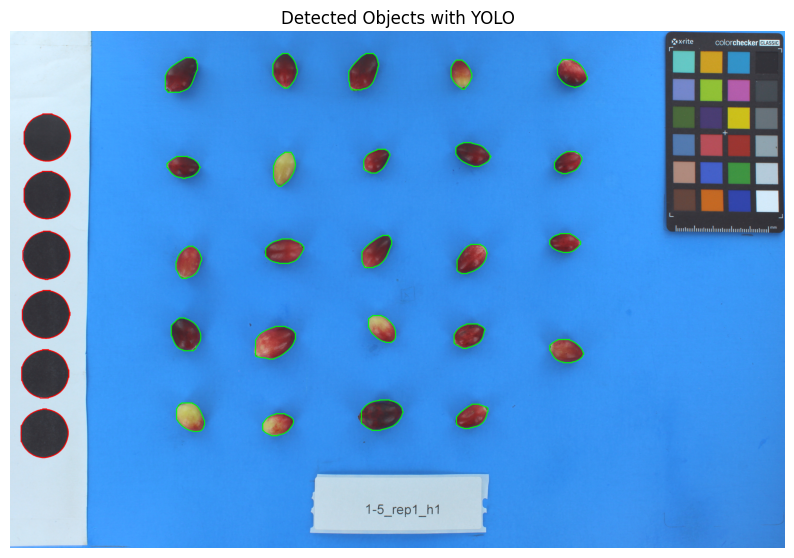

In [ ]:
# Step 3: Detect size markers and berries

#load the yolo model
print("Loading models...")
yolo_model = YOLO(yolo_model_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
yolo_model.to(device)


cran.find_objects_yolo(yolo_model)

# Draw contours on the image
for contour in cran.berry_contours:
    cv2.drawContours(cran.img, [contour], -1, (0, 255, 0), 5)  # Green for cranberries
for contour in cran.marker_contours:
    cv2.drawContours(cran.img, [contour], -1, (0, 0, 255), 5)  # Red for size markers

# Visualize detected size markers and berries
show_image(cran.img, title='Detected Objects with YOLO')

In [ ]:
# Step 4: Measure berries
cran.measure_berries()

In [ ]:
# Step 5: Measure color
cran.measure_color()

In [ ]:
# Step 6: (Optional) Sort berries
#Will sort berries into rows and columns
cran.sort_berries()

In [ ]:
# Step 7: (Optional) Convert measurements to cm
#Diameter in cm of size marker. If this step is skipped, sizes will be reported in pixels
size = 1
cran.convert_to_cm(float(size))

In [ ]:
# Display example measurements
cran.berry_df.head()

,dir,filename,berry,row,column,length_cm,width_cm,length_vs_width,area_cm2,perimeter_cm,...,color_a_median,color_a_sd,color_b_median,color_b_sd,color_R_median,color_R_sd,color_G_median,color_G_sd,color_B_median,color_B_sd
23,/content/drive/MyDrive/ColabNotebooks/Cranberr...,1-5_rep1_h1.jpg,1,1,1,0.912299,0.585366,1.558511,0.370855,2.428646,...,17.0,8.694065,2.0,8.341180,82.0,22.850607,45.0,19.302023,54.0,18.104888
13,/content/drive/MyDrive/ColabNotebooks/Cranberr...,1-5_rep1_h1.jpg,2,1,2,0.731707,0.532434,1.374269,0.282390,2.083031,...,27.0,9.334654,8.0,10.010246,103.0,26.354142,45.0,17.256612,54.0,14.718049
16,/content/drive/MyDrive/ColabNotebooks/Cranberr...,1-5_rep1_h1.jpg,3,1,3,0.906072,0.579139,1.564516,0.363061,2.406850,...,21.0,8.898403,3.0,8.679066,88.0,22.203417,45.0,17.469976,52.0,14.119428
18,/content/drive/MyDrive/ColabNotebooks/Cranberr...,1-5_rep1_h1.jpg,4,1,4,0.656980,0.470161,1.397351,0.204900,1.809030,...,25.0,13.229873,23.0,14.402633,153.0,27.436609,88.0,38.819216,70.0,20.258189
4,/content/drive/MyDrive/ColabNotebooks/Cranberr...,1-5_rep1_h1.jpg,5,1,5,0.700571,0.535547,1.308140,0.278764,2.064349,...,32.0,11.095275,13.0,11.596554,125.0,44.640895,51.0,26.668680,62.0,22.364715
